In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
dataid = np.load("./homeid_10_hourly.npy")
validid = np.load("./valid_homes_index.npy")
homeid = dataid[validid]

In [3]:
labels = [1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2,
       0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2,
       2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1]
cluster = {}
for i in range(3):
    cluster[i] = [x for x in range(68) if labels[x] == i]

In [172]:
# prediction of three methods
# for STF
true_pred = np.load("../code/baseline/result/mtf-pred-12.npy").item()[2]
artificial_pred = np.load("../code/baseline/result/mtf-pred-12.npy").item()[1]
subtract_pred = np.load("../code/baseline/result/mtf-pred-34.npy").item()[3]

In [173]:
# gt
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test


gt_tensor = np.ones([68, 5, 112, 24])
start = 0
for fold_num in range(5):
    train, test = get_train_test(1, 5, fold_num)
#     if fold_num == 0:
#         print(test)
    length = len(test)
    gt_tensor[start:start+length] = test[:, 1:, : :]
    start = start + length

In [174]:
true_pred_tensor = np.ones([68, 5, 112, 24])
start = 0
for i in range(5):
    length = len(true_pred[i])
    true_pred_tensor[start:start+length] = true_pred[i]
    start = start + length

artificial_pred_tensor = np.ones([68, 5, 112, 24])
start = 0
for i in range(5):
    length = len(artificial_pred[i])
    artificial_pred_tensor[start:start+length] = artificial_pred[i]
    start = start + length
    
subtract_pred_tensor = np.ones([68, 5, 112, 24])
start = 0
for i in range(5):
    length = len(subtract_pred[i])
    subtract_pred_tensor[start:start+length] = subtract_pred[i]
    start = start + length
    

In [175]:
APPLIANCE_ORDER = ['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw']
from sklearn.metrics import mean_absolute_error


In [176]:
# for true_pred_tensor
true_cluster_error = {}
for c in range(3):
#     print(cluster[i])
    pred = true_pred_tensor[cluster[c]]
    gt = gt_tensor[cluster[c]]
    test_error = {APPLIANCE_ORDER[i+1]:mean_absolute_error(pred[:, i,:,:].flatten(), 
                                                       gt[:, i, :, :].flatten()) for i in range(pred.shape[1])}
    true_cluster_error[c] = test_error

In [177]:
# for artificial_pred_tensor
artificial_cluster_error = {}
for c in range(3):
#     print(cluster[i])
    pred = artificial_pred_tensor[cluster[c]]
    gt = gt_tensor[cluster[c]]
    test_error = {APPLIANCE_ORDER[i+1]:mean_absolute_error(pred[:, i,:,:].flatten(), 
                                                       gt[:, i, :, :].flatten()) for i in range(pred.shape[1])}
    artificial_cluster_error[c] = test_error

In [178]:
# for subtract_pred_tensor
subtract_cluster_error = {}
for c in range(3):
#     print(cluster[i])
    pred = subtract_pred_tensor[cluster[c]]
    gt = gt_tensor[cluster[c]]
    test_error = {APPLIANCE_ORDER[i+1]:mean_absolute_error(pred[:, i,:,:].flatten(), 
                                                       gt[:, i, :, :].flatten()) for i in range(pred.shape[1])}
    subtract_cluster_error[c] = test_error

Text(0.5,1,'MTF Prediction Error of 3 Clusters on 3 Different Datasets')

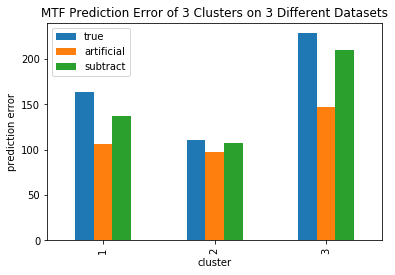

In [180]:
df= pd.DataFrame(true_cluster_error).mean(axis=0)
df = pd.concat([df, pd.DataFrame(artificial_cluster_error).mean(axis=0)], axis=1)
df = df.rename(columns={0:'true', 1:'artificial'})
df = pd.concat([df, pd.DataFrame(subtract_cluster_error).mean(axis=0)], axis=1)
df = df.rename(columns={0:'subtract'})
df = df.rename(index={0:1, 1:2, 2:3})
ax = df.plot(kind='bar')
ax.set_xlabel("cluster")
ax.set_ylabel("prediction error")
ax.set_title('MTF Prediction Error of 3 Clusters on 3 Different Datasets')